In [36]:
import pandas as pd
import os
from pathlib import Path
from matplotlib import pyplot as plt
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats

In [13]:
# work from the project root
if os.getcwd().endswith('notebooks'):
    os.chdir("..")

In [14]:
outputs_root = Path('tfl_project/data/simulation_outputs')
dbpath = Path('tfl_project/data/bike_db.db')

In [44]:
def evaluate_sim(sim_id: str, t:int):
    df = pd.read_csv(outputs_root / sim_id / 'time_series.csv')
    ax = df.pivot_table(index='time', columns='sim_num').cumsum().stack(0).mean(axis=1).unstack().plot()
    stats = df.groupby('sim_num').sum().drop('time', axis=1)
    stats['combined_faults'] = stats['failed_starts'] + stats['failed_ends']
    stats = stats.agg(['mean','std', 'sem', 'var','min','max'])
    stats.loc['ci_95'] = t*stats.loc['sem']
    return stats, ax

In [45]:
def mean_events_by_station(sim_id: str):

    df = pd.read_csv(outputs_root / sim_id / 'events.csv')
    # sumarise average destination events
    dests = df.groupby(['end_st','sim_num','event']).size() \
        .unstack('sim_num') \
        .mean(axis=1) \
        .unstack(fill_value=0) \
        .drop('failed_starts',1)

    # sumarise average origin events
    origins = df.groupby(['start_st','sim_num','event']).size() \
        .unstack('sim_num') \
        .mean(axis=1) \
        .unstack(fill_value=0) \
        .drop(['failed_ends', 'finished_journeys'],1)

    st_summ = pd.merge(dests, origins, left_index=True, right_index=True)
    st_summ.index.name = 'station'
    
    st_summ['combined_faults'] = st_summ['failed_ends'] + st_summ['failed_starts']
    st_summ['pct_failed_starts'] = 0
    st_summ['pct_failed_starts'].where(
            st_summ['combined_faults'] == 0
            ,st_summ['failed_starts'] / st_summ['combined_faults']
            ,inplace=True
    )
    
    return st_summ

In [46]:
def append_meta_data(df):
    db = sqlite3.connect(dbpath)
    query = ("SELECT bikepoint_id, common_name, latitude, longitude FROM station_metadata")
    metadata = pd.read_sql_query(query, db)
    df2 = pd.merge(df, metadata, left_index=True, right_on='bikepoint_id').drop('bikepoint_id',1)
    return df2

In [47]:
def plot_st_summ_map(df):
    
    fig = px.scatter_mapbox(
        data_frame=df
        ,lat='latitude'
        ,lon='longitude'
        ,hover_name ='common_name'
        ,size='combined_faults'
        ,color='pct_failed_starts'
        ,zoom=11
        ,color_continuous_scale='cividis'
        #,=0.5
    )
    
    fig.update_geos(
        fitbounds='locations'
        ,projection_type='transverse mercator'
    )

    fig.update_layout(
        mapbox_style="carto-positron"
        #mapbox_style='dark'
    )

    return fig

In [48]:
def summ_and_plot_by_st(sim_id: str):
    st_summ = mean_events_by_station(sim_id)
    st_summ_2 = append_meta_data(st_summ)
    ax = plot_st_summ_map(st_summ_2)
    return st_summ, ax

## Wrap the evaluatins in one function:

In [51]:
def all_evals(sim_id: str, t: int):
    stats, ax1 = evaluate_sim(sim_id, t)
    st_summ, ax2 = summ_and_plot_by_st(sim_id)
    print()
    print(sim_id, '*'*50)
    print()
    print(stats)
    ax2.show()
    plt.show()
    


SIM0_BASE_5AM_NO_REBAL **************************************************

       failed_starts   failed_ends  finished_journeys  combined_faults
mean     2346.400000   3511.400000       28151.750000      5857.800000
std        76.294030    214.245899         200.857340       195.518905
sem        17.059864     47.906839          44.913067        43.719356
var      5820.778947  45901.305263       40343.671053     38227.642105
min      2225.000000   3073.000000       27773.000000      5511.000000
max      2514.000000   3808.000000       28561.000000      6120.000000
ci_95      35.706295    100.269015          94.003048        91.504612


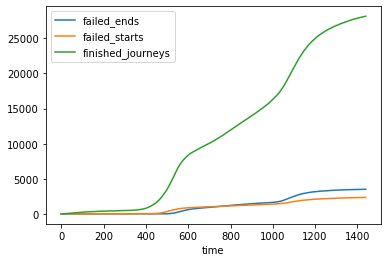


SIM1_BIG_WAREHOUSE_5AM_NO_REBAL **************************************************

       failed_starts   failed_ends  finished_journeys  combined_faults
mean     1506.850000   2980.500000       29063.500000      4487.350000
std        82.183540    236.071466         164.851289       244.856838
sem        18.376798     52.787184          36.861869        54.751653
var      6754.134211  55729.736842       27175.947368     59954.871053
min      1386.000000   2392.000000       28812.000000      3876.000000
max      1700.000000   3479.000000       29399.000000      4932.000000
ci_95      38.462639    110.483577          77.151891       114.595211


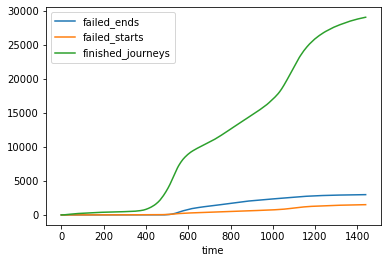


SIM2.1_MORECAPACITY_TYPE_A_ALLOC **************************************************

       failed_starts  failed_ends  finished_journeys  combined_faults
mean     2319.650000   637.300000       28156.550000      2956.950000
std       103.838070    98.196420         145.085991       160.685202
sem        23.218898    21.957387          32.442214        35.930304
var     10782.344737  9642.536842       21049.944737     25819.734211
min      2116.000000   491.000000       27898.000000      2685.000000
max      2466.000000   847.000000       28407.000000      3242.000000
ci_95      48.597154    45.956811          67.901554        75.202125


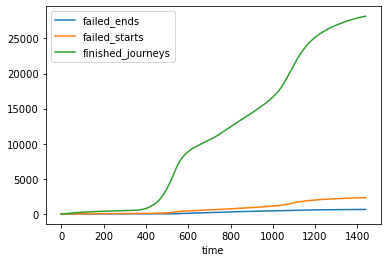


SIM2.2_MORECAPACITY_TYPE_B_ALLOC **************************************************

       failed_starts   failed_ends  finished_journeys  combined_faults
mean     1243.150000   1016.800000       29291.650000      2259.950000
std        65.878097    122.083061         113.611654       148.609511
sem        14.730790     27.298602          25.404338        33.230097
var      4339.923684  14904.273684       12907.607895     22084.786842
min      1107.000000    781.000000       29145.000000      1987.000000
max      1376.000000   1350.000000       29516.000000      2645.000000
ci_95      30.831544     57.135974          53.171280        69.550593


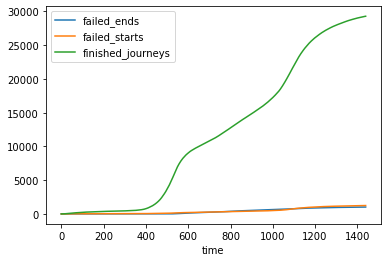


SIM3_SQUEEZED_TYPE_C_ALLOC **************************************************

       failed_starts   failed_ends  finished_journeys  combined_faults
mean     1279.800000   2535.300000       29216.750000      3815.100000
std        74.249650    196.461889         135.768718       219.378284
sem        16.602726     43.930214          30.358808        49.054476
var      5513.010526  38597.273684       18433.144737     48126.831579
min      1077.000000   2145.000000       28976.000000      3314.000000
max      1398.000000   2894.000000       29445.000000      4117.000000
ci_95      34.749507     91.945937          63.540986       102.671017


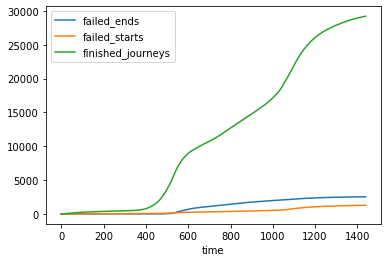

In [52]:
for sim_id in ['SIM0_BASE_5AM_NO_REBAL', 'SIM1_BIG_WAREHOUSE_5AM_NO_REBAL', 'SIM2.1_MORECAPACITY_TYPE_A_ALLOC', 'SIM2.2_MORECAPACITY_TYPE_B_ALLOC', 'SIM3_SQUEEZED_TYPE_C_ALLOC']:
    all_evals(sim_id, t=2.09302);